In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns

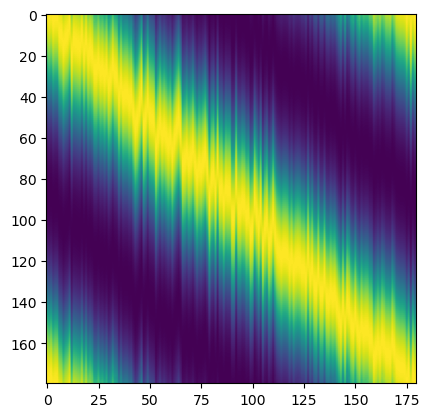

In [293]:
plt.imshow( random_drift(WFF_init))

In [306]:
matrix = random_drift(WFF_init)

gamma = 0.3

for i in range(matrix.shape[0]):
        max_column = np.argmax(matrix[:, i])
        if (max_column-i) > 90 or (max_column-i) < -90:
                difference = 180 - delta_a * np.sign(delta_a)
        else: difference = (max_column - i)
        perturbation = int(np.random.normal(0, 5)) - round(gamma * difference)

        # matrix[:, i] = np.roll(matrix[:, i], int(np.random.normal(0, 5)))

In [280]:
np.sign(delta_a)

-1

In [307]:
def phi(x):
    # a = 1
    # b = 0.25
    # n = 2
    # return a * np.maximum((x-b), 0)**n
    return 1/(1+np.exp(-x))

def ori_matrix(x, mean, var):
    return stats.norm.pdf(x, mean, var) + stats.norm.pdf(x, mean+180, var) + stats.norm.pdf(x, mean-180, var) 

def weight_normalisation(matrix):
    return matrix / np.sum(matrix, axis=0)

def get_input(N, theta):

    theta_y = np.linspace(0, 180, N) # center of tuning curves 
    d = np.abs(theta - theta_y)      # distance to input theta
    sigma = 8                       # response width
    amp = 300                         # response amplitude

    y = amp * np.exp(-(d**2)/(2*sigma**2))

    return y

def random_drift(matrix, gamma=0.1):

    for i in range(matrix.shape[0]):
            max_column = np.argmax(matrix[:, i])
            if (max_column-i) > 90 or (max_column-i) < -90:
                    difference = 180 - delta_a * np.sign(delta_a)
            else: difference = (max_column - i)
            perturbation = int(np.random.normal(0, 5)) - round(gamma * difference)
            matrix[:, i] = np.roll(matrix[:, i], perturbation)
    return matrix 

def simulate(input, WFF_init, T, drift=True):
    timesteps = int(T / delta_t)

    # initialisation
    I = np.ones((N, timesteps))   
    E = np.zeros((N, timesteps))    
    E[:, 0] = np.random.normal(N) * 0.1      # initial E activations
    I[:, 0] = np.random.normal(N) * 0.1     # initial I activations

    WFF = np.zeros((N, N, timesteps))      # feedforward weights
    WFF[:, :, 0] = WFF_init

    for i in range(timesteps - 1):
        
        E[:, i + 1] = E[:, i] + delta_t * (
            - E[:, i] 
            + np.dot(W_EE, phi(E[:, i]))
            - np.dot(W_EI, phi(I[:, i]))
            + np.dot(WFF[:, :, i], (input))
        ) / tau_E

        I[:, i + 1] = I[:, i] + delta_t * (
            - I[:, i] 
            + np.dot(W_IE, phi(E[:, i]))
        ) / tau_E

        if drift:
            WFF[:, :, i + 1] = random_drift(WFF[:, :, i]) 

        # if plasticity == True:
        #     WFF[:, :, i + 1] = WFF[:, :, i] + delta_t * (
        #         epsilon * np.outer(input, phi(E[:, i]))
        #     ) / tau_weights

        #     WFF[:, :, i + 1] = weight_normalisation(WFF[:, :, i + 1])

        else: WFF[:, :, i + 1] = WFF[:, :, i]

    return E, WFF

In [308]:
N = int(180)   # number of neurons per layer
delta_t = 0.1 

tau_E = 20  # 20 for exc, 10 for inh 
tau_weights = 40
epsilon = 0.001        # learning rate for the weights

WFF_init = np.zeros((N, N))
W_EE = np.zeros((N, N))      # recurrent weights
W_EI = np.zeros((N, N))      # I -> E weights
W_IE = np.zeros((N, N))      # E -> I weights

x = np.linspace(0, 180, N)
W_FF_var = 30                 # variance of weights
W_EE_var = 30              
W_IE_var = 30
W_EI_var = 30

for i in range(N):
    WFF_init[:, i] = ori_matrix(x, x[i], W_FF_var) 
    W_EE[:, i] = ori_matrix(x, x[i], W_EE_var) 
    W_IE[:, i] = ori_matrix(x, x[i], W_IE_var) 
    W_EI[:, i] = (ori_matrix(x, x[i], W_EI_var) - ori_matrix(x, x[i], W_EI_var-15)) * 3


In [309]:
T = 100
theta = 40
y = get_input(N, theta)

E, WFF = simulate(y, WFF_init, T)

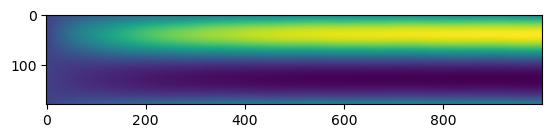

In [310]:
plt.imshow(E)

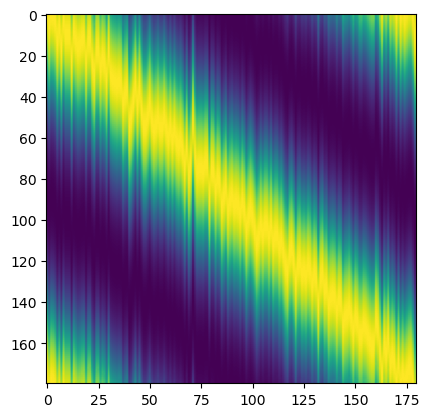

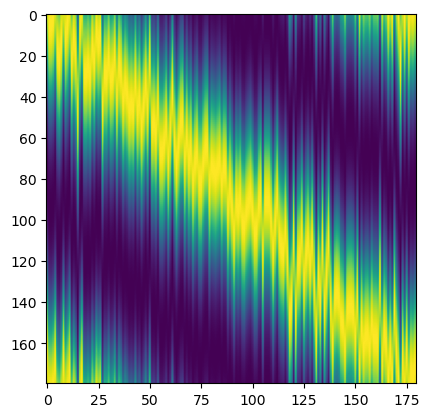

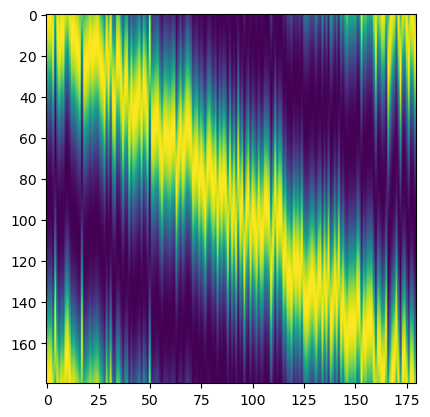

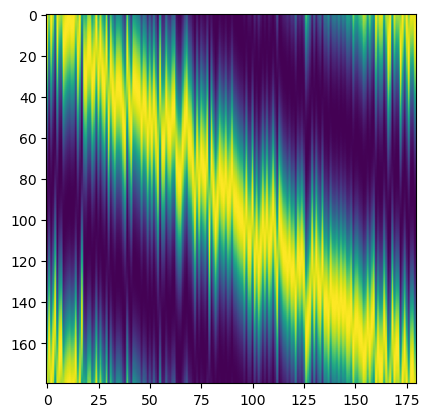

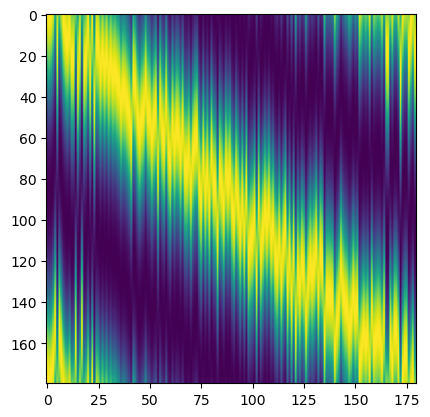

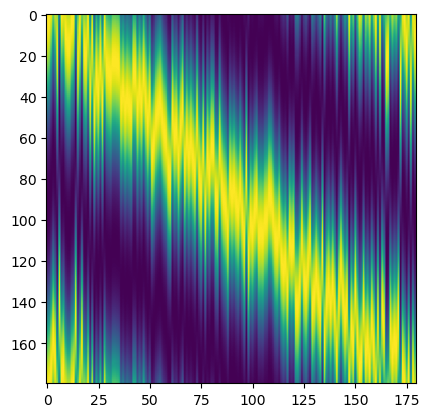

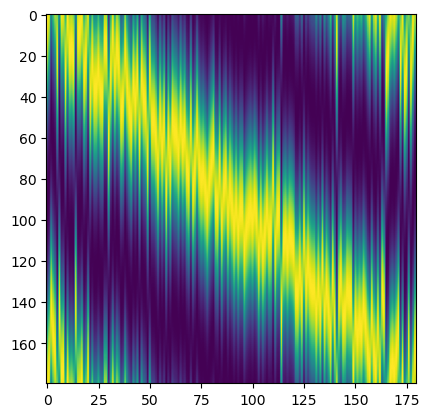

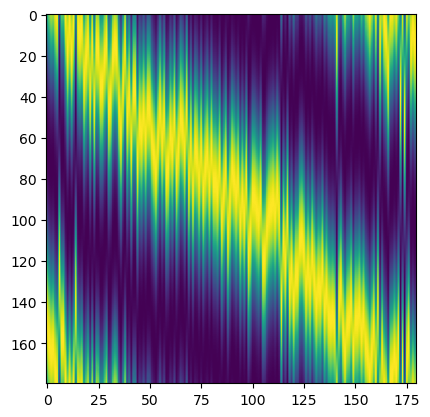

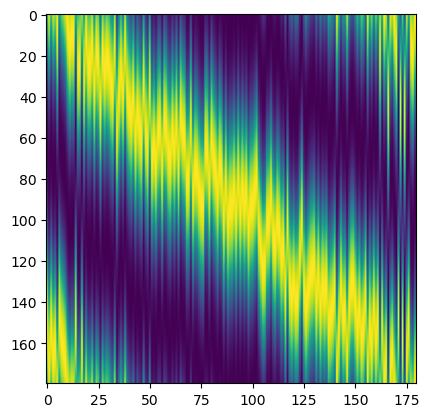

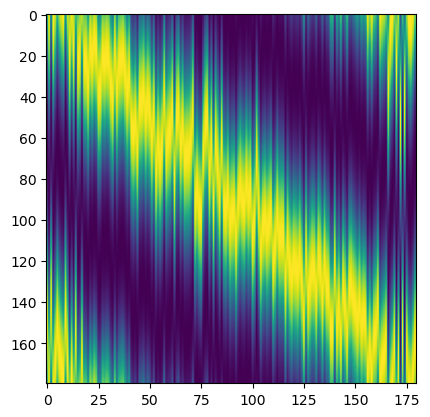

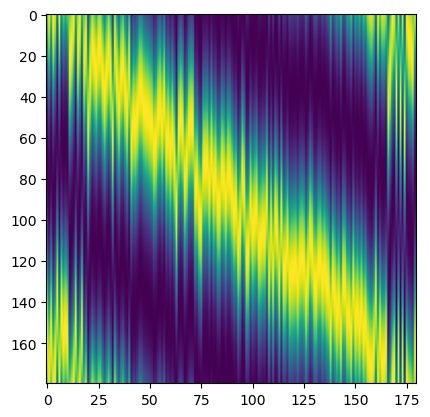

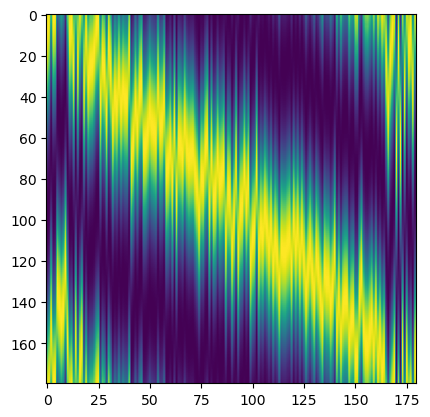

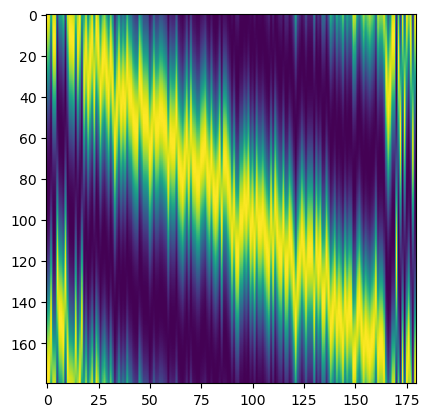

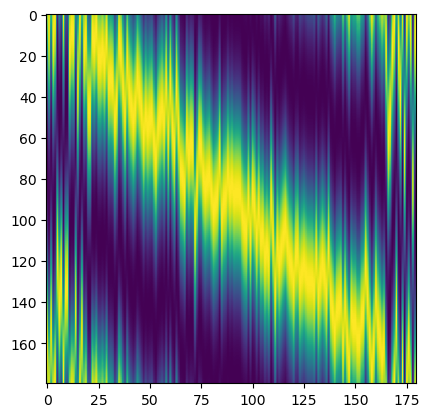

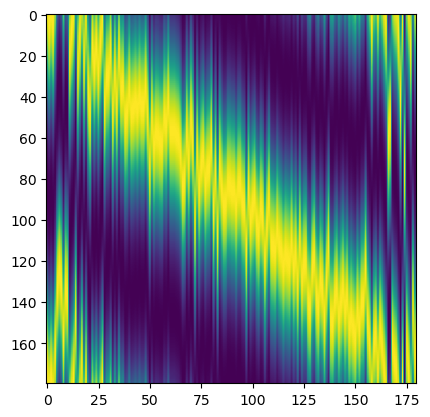

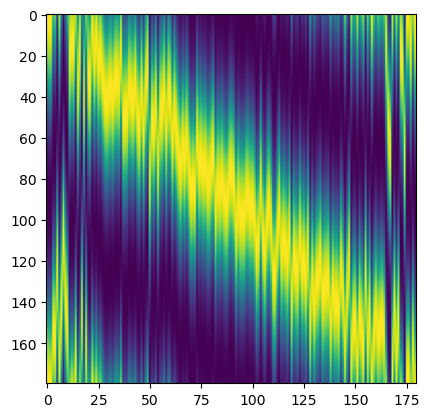

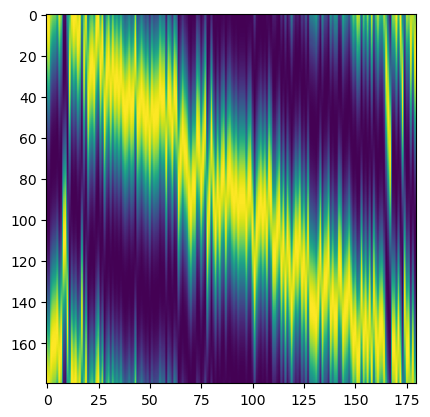

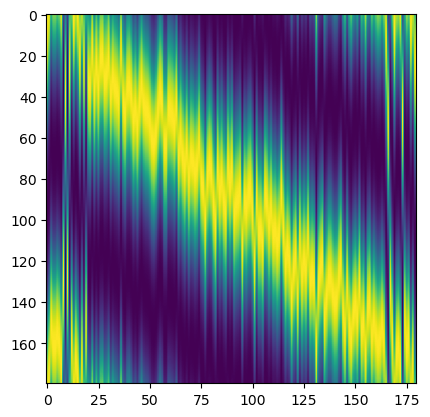

In [311]:
for i in np.arange(0, 180, 10):
    plt.imshow(WFF[:, :, i])
    plt.show()

In [312]:
def test_tuning(T, angles, E, WFF):

    responses = []
    for theta in angles:
        y = get_input(N, theta)
        E, WFF = simulate(y, WFF[:, :, -1], T, drift=False)
        responses.append(E[:, -1][None])
    
    tuning_tests = np.concatenate(responses, axis=0).T

    return tuning_tests, WFF


In [313]:
T_test = 8
angles = np.linspace(0, 180, 60)
theta = 40
y = get_input(N, theta)


# Drift 
E_new, W_FF_new = simulate(y, WFF_init, 100, drift=True)

# Test
tuning, W_FF_new = test_tuning(T_test, angles, E_new, W_FF_new)

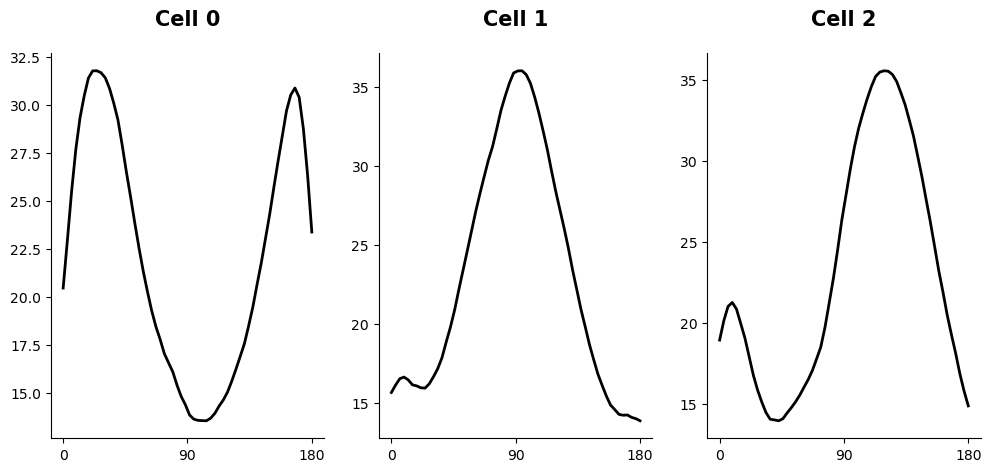

In [314]:

n_cells = 3

fig, axs = plt.subplots(1, n_cells, figsize=(12, 5), dpi=100)

pref_angles = [10, 90, 120]


for j in range(n_cells):
    axs[j].plot(angles, tuning[pref_angles[j], :], lw=2, c='k')
    axs[j].set_xticks([0, 90, 180])
    axs[j].set_xticklabels([0, 90, 180])
    sns.despine(ax=axs[j])

    axs[j].set_title('Cell %s' %j, fontsize=15, pad=20, weight='bold')
    # if j==0: axs[i, j].set_ylabel('Day %s' %i,  fontsize=15, labelpad=10, weight='bold')

    
